In [ ]:
!pip install emoji
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 11.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import json
from pprint import pprint

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Text processing libraries
import emoji
import re
import contractions
from collections import Counter
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
# Scikit-Learn packages
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import precision_recall_fscore_support


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/ML-Project-NLP-TrVal-Datasets/EmoTrain.csv')
df_val = pd.read_csv('/content/drive/MyDrive/ML-Project-NLP-TrVal-Datasets/EmoVal.csv')

# Preview of data
display(df_train.head())

,Unnamed: 0,text,praise,amusement,anger,disapproval,confusion,interest,sadness,fear,joy,love
0,0,Is there some scripture you could quote me? I'...,1,0,0,0,0,1,0,0,0,0
1,1,Good. Now we just need people to dislike commi...,1,0,0,0,0,0,0,0,0,0
2,2,This was driving me NUTS!,0,1,0,0,0,0,0,0,0,0
3,3,Thank you for your advice!,0,0,0,0,0,0,0,0,0,1
4,4,Some do. Some don't. Blanket generalizations a...,0,0,1,1,0,0,0,0,0,0


In [ ]:
size_train = df_train.shape[0]
size_val = df_val.shape[0]

# Defining the total number of samples
size_all = size_train + size_val

In [ ]:
print("Trainset has {} samples and represents {:.2f}% ".format(size_train, size_train/size_all*100))
print("Valset has {} samples and represents {:.2f}%".format(size_val, size_val/size_all*100))
print()
print("The total number of samples is : {}".format(size_all))

Trainset has 190102 samples and represents 94.74% 
Valset has 10562 samples and represents 5.26%

The total number of samples is : 200664


In [ ]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190102 entries, 0 to 190101
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Unnamed: 0   190102 non-null  int64 
 1   text         190102 non-null  object
 2   praise       190102 non-null  int64 
 3   amusement    190102 non-null  int64 
 4   anger        190102 non-null  int64 
 5   disapproval  190102 non-null  int64 
 6   confusion    190102 non-null  int64 
 7   interest     190102 non-null  int64 
 8   sadness      190102 non-null  int64 
 9   fear         190102 non-null  int64 
 10  joy          190102 non-null  int64 
 11  love         190102 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 17.4+ MB


In [ ]:
with open("/content/drive/MyDrive/ML-Project-NLP-TrVal-Datasets/emotions.txt", "r") as file:
    GE_taxonomy = file.read().split("\n")

for emo in GE_taxonomy:
  print(emo)

praise
amusement	
anger	
disapproval	
confusion	
interest	
sadness	
fear	
joy
love



In [ ]:
df_all = pd.concat([df_train, df_val], axis=0).reset_index(drop=True)

# Preview of data
display(df_all.head(3))

print(df_all.shape)

,Unnamed: 0,text,praise,amusement,anger,disapproval,confusion,interest,sadness,fear,joy,love
0,0,Is there some scripture you could quote me? I'...,1,0,0,0,0,1,0,0,0,0
1,1,Good. Now we just need people to dislike commi...,1,0,0,0,0,0,0,0,0,0
2,2,This was driving me NUTS!,0,1,0,0,0,0,0,0,0,0


(200664, 12)


In [ ]:
# Convertings emotion indices into list of indices
# Check if 'GE_indices' column exists before accessing it
if 'GE_indices' in df_all.columns:
    df_all['GE_indices'] = df_all['GE_indices'].astype(str).apply(lambda x: x.split(','))
else:
    # Print an error message or handle the missing column accordingly
    print("Column 'GE_indices' not found in the DataFrame.")
    # You can also check the column names using:
    print("Available columns:", df_all.columns)

# Preview of data
display(df_all.head(3))

Column 'GE_indices' not found in the DataFrame.
Available columns: Index(['Unnamed: 0', 'text', 'praise', 'amusement', 'anger', 'disapproval',
       'confusion', 'interest', 'sadness', 'fear', 'joy', 'love'],
      dtype='object')


,Unnamed: 0,text,praise,amusement,anger,disapproval,confusion,interest,sadness,fear,joy,love
0,0,Is there some scripture you could quote me? I'...,1,0,0,0,0,1,0,0,0,0
1,1,Good. Now we just need people to dislike commi...,1,0,0,0,0,0,0,0,0,0
2,2,This was driving me NUTS!,0,1,0,0,0,0,0,0,0,0


In [ ]:
# Visualising a random text sample from our dataset
text_sample = np.random.randint(len(df_all))

# Check if the 'Text' column exists; if not, try alternative names
if 'Text' in df_all.columns:
    print(df_all.loc[text_sample, "Text"])
elif 'text' in df_all.columns:
    print(df_all.loc[text_sample, "text"])
elif 'Tweet' in df_all.columns: # Add other potential column names here
    print(df_all.loc[text_sample, "Tweet"])
else:
    print("Column 'Text' or similar not found in the DataFrame.")
    print("Available columns:", df_all.columns)

I just enjoy feasting off tears ....mmmmm


In [ ]:
import re
import emoji
import contractions

def preprocess_corpus(x):
    # Adding a space between words and punctuation
    x = re.sub(r'([a-zA-Z])([,;.!?])', r'\1 \2', x)
    x = re.sub(r'([,;.!?])([a-zA-Z])', r'\1 \2', x)

    # Demojize
    x = emoji.demojize(x)

    # Expand contractions
    x = contractions.fix(x)

    # Lowercase the text
    x = x.lower()

    # Correct some acronyms/typos/abbreviations
    x = re.sub(r"\blmao\b", "laughing my ass off", x)
    x = re.sub(r"\bamirite\b", "am i right", x)
    x = re.sub(r"\btho\b", "though", x)
    x = re.sub(r"\bikr\b", "i know right", x)
    x = re.sub(r"\b(ya|u)\b", "you", x)
    x = re.sub(r"\beu\b", "europe", x)
    x = re.sub(r"\bda\b", "the", x)
    x = re.sub(r"\b(dat)\b", "that", x)
    x = re.sub(r"\bdats\b", "that is", x)
    x = re.sub(r"\bcuz\b", "because", x)
    x = re.sub(r"\bfkn\b", "fucking", x)
    x = re.sub(r"\btbh\b", "to be honest", x)
    x = re.sub(r"\btbf\b", "to be fair", x)
    x = re.sub(r"faux pas", "mistake", x)
    x = re.sub(r"\bbtw\b", "by the way", x)
    x = re.sub(r"\bbs\b", "bullshit", x)
    x = re.sub(r"\bkinda\b", "kind of", x)
    x = re.sub(r"\bbruh\b", "bro", x)
    x = re.sub(r"\bw/e\b", "whatever", x)
    x = re.sub(r"\bw/\b", "with", x)
    x = re.sub(r"\bw/o\b", "without", x)
    x = re.sub(r"\bdoj\b", "department of justice", x)

    # Replace some words with multiple occurrences of a letter, example "coooool" turns into --> cool
    x = re.sub(r"\b(j+e{2,}z+e*)\b", "jeez", x)
    x = re.sub(r"\b(co+l+)\b", "cool", x)
    x = re.sub(r"\b(g+o+a+l+)\b", "goal", x)
    x = re.sub(r"\b(s+h+i+t+)\b", "shit", x)
    x = re.sub(r"\b(o+m+g+)\b", "omg", x)
    x = re.sub(r"\b(w+t+f+)\b", "wtf", x)
    x = re.sub(r"\b(w+h+a+t+)\b", "what", x)
    x = re.sub(r"\b(y+e+y+|y+a+y+|y+e+a+h+)\b", "yeah", x)
    x = re.sub(r"\b(w+o+w+)\b", "wow", x)
    x = re.sub(r"\b(w+h+y+)\b", "why", x)
    x = re.sub(r"\b(s+o+)\b", "so", x)
    x = re.sub(r"\b(f)\b", "fuck", x)
    x = re.sub(r"\b(w+h+o+p+s+)\b", "whoops", x)
    x = re.sub(r"\b(ofc)\b", "of course", x)
    x = re.sub(r"\b(the us)\b", "usa", x)
    x = re.sub(r"\b(gf)\b", "girlfriend", x)
    x = re.sub(r"\b(hr)\b", "human resources", x)
    x = re.sub(r"\b(mh)\b", "mental health", x)
    x = re.sub(r"\b(idk)\b", "i do not know", x)
    x = re.sub(r"\b(gotcha)\b", "i got you", x)
    x = re.sub(r"\b(y+e+p+)\b", "yes", x)
    x = re.sub(r"\b(a*ha+h[ha]*|a*ha +h[ha]*)\b", "haha", x)
    x = re.sub(r"\b(o?l+o+l+[ol]*)\b", "lol", x)
    x = re.sub(r"\b(o*ho+h[ho]*|o*ho +h[ho]*)\b", "ohoh", x)
    x = re.sub(r"\b(o+h+)\b", "oh", x)
    x = re.sub(r"\b(a+h+)\b", "ah", x)
    x = re.sub(r"\b(u+h+)\b", "uh", x)

    # Handling emojis
    x = re.sub(r"<3", " love ", x)
    x = re.sub(r"xd", " smiling_face_with_open_mouth_and_tightly_closed_eyes ", x)
    x = re.sub(r":\)", " smiling_face ", x)
    x = re.sub(r"^_^", " smiling_face ", x)
    x = re.sub(r"\*_\*", " star_struck ", x)
    x = re.sub(r":\(", " frowning_face ", x)
    x = re.sub(r":\^\(", " frowning_face ", x)
    x = re.sub(r";\(", " frowning_face ", x)
    x = re.sub(r":\/",  " confused_face", x)
    x = re.sub(r";\)",  " wink", x)
    x = re.sub(r">__<",  " unamused ", x)
    x = re.sub(r"\b([xo]+x*)\b", " xoxo ", x)
    x = re.sub(r"\b(n+a+h+)\b", "no", x)

    # Handling special cases of text
    x = re.sub(r"h a m b e r d e r s", "hamberders", x)
    x = re.sub(r"b e n", "ben", x)
    x = re.sub(r"s a t i r e", "satire", x)
    x = re.sub(r"y i k e s", "yikes", x)
    x = re.sub(r"s p o i l e r", "spoiler", x)
    x = re.sub(r"thankyou", "thank you", x)
    x = re.sub(r"a^r^o^o^o^o^o^o^o^n^d", "around", x)

    # Remove special characters and numbers, replace them with space + remove double space
    x = re.sub(r"\b([.]{3,})", " dots ", x)
    x = re.sub(r"[^A-Za-z!?_]+", " ", x)
    x = re.sub(r"\b([s])\b *", "", x)
    x = re.sub(r" +", " ", x)
    x = x.strip()

    return x


In [ ]:
df_all["Clean_text"] = df_all["text"].apply(preprocess_corpus)
# Change "Tweet" to the actual name of the column containing the raw text data
# Based on the previous code, it's likely the column is named 'text'

# Preview of data
display(df_all[['text', 'Clean_text']].sample(5))
# Also change 'Tweet' to 'text' here for consistency

,text,Clean_text
70204,“Children transing is abuse though ... and I'm...,children transing is abuse though and i am not...
78038,"Also, money. It is a cost-prohibitive procedur...",also money it is a cost prohibitive procedure ...
107344,[NAME] is pretty dry but he's great for down t...,name is pretty dry but he is great for down to...
191012,I don’t know who the hell [NAME] is but I am n...,i do not know who the hell name is but i am no...
186506,"Wow! If they were to follow that logic, they w...",wow ! if they were to follow that logic they w...


In [ ]:
# Remove columns with names 'Unnamed:' and 'Text' while keeping only 'Clean_text' once
df_all = df_all.loc[:, ~df_all.columns.str.contains('^Unnamed:|Text')]

# Preview of data
display(df_all.head(5))


,text,praise,amusement,anger,disapproval,confusion,interest,sadness,fear,joy,love,Clean_text
0,Is there some scripture you could quote me? I'...,1,0,0,0,0,1,0,0,0,0,is there some scripture you could quote me ? i...
1,Good. Now we just need people to dislike commi...,1,0,0,0,0,0,0,0,0,0,good now we just need people to dislike commie...
2,This was driving me NUTS!,0,1,0,0,0,0,0,0,0,0,this was driving me nuts !
3,Thank you for your advice!,0,0,0,0,0,0,0,0,0,1,thank you for your advice !
4,Some do. Some don't. Blanket generalizations a...,0,0,1,1,0,0,0,0,0,0,some do some do not blanket generalizations ar...


In [ ]:
def get_train_val_test(df):
    train = df.iloc[:size_train, :]
    val = df.iloc[size_train:size_train+size_val, :]
    return train, val

In [ ]:
# Dividing back in train, validation and test datasets (GoEmotions)
train_GE, val_GE = get_train_val_test(df_all)
print(train_GE.shape)
print(val_GE.shape)

(190102, 12)
(10562, 12)


In [ ]:
display(train_GE.head(3))


,text,praise,amusement,anger,disapproval,confusion,interest,sadness,fear,joy,love,Clean_text
0,Is there some scripture you could quote me? I'...,1,0,0,0,0,1,0,0,0,0,is there some scripture you could quote me ? i...
1,Good. Now we just need people to dislike commi...,1,0,0,0,0,0,0,0,0,0,good now we just need people to dislike commie...
2,This was driving me NUTS!,0,1,0,0,0,0,0,0,0,0,this was driving me nuts !


In [ ]:
# Clean up GE_taxonomy by removing trailing tabs and empty strings:
GE_taxonomy = [emo.strip() for emo in GE_taxonomy if emo.strip()]

# Computing the number of labels for each sample
train_GE['Cardinality'] = train_GE.loc[:, GE_taxonomy].apply(lambda x: sum(x), axis=1)

# Preview of data
display(train_GE.head(3))

<ipython-input-19-0e1adcf5f684>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_GE['Cardinality'] = train_GE.loc[:, GE_taxonomy].apply(lambda x: sum(x), axis=1)


,text,praise,amusement,anger,disapproval,confusion,interest,sadness,fear,joy,love,Clean_text,Cardinality
0,Is there some scripture you could quote me? I'...,1,0,0,0,0,1,0,0,0,0,is there some scripture you could quote me ? i...,2
1,Good. Now we just need people to dislike commi...,1,0,0,0,0,0,0,0,0,0,good now we just need people to dislike commie...,1
2,This was driving me NUTS!,0,1,0,0,0,0,0,0,0,0,this was driving me nuts !,1


In [ ]:
train_GE['Cardinality'].value_counts()


,count
Cardinality,
1,159291
2,25086
0,3058
3,2399
4,213
5,37
6,12
8,3
7,2


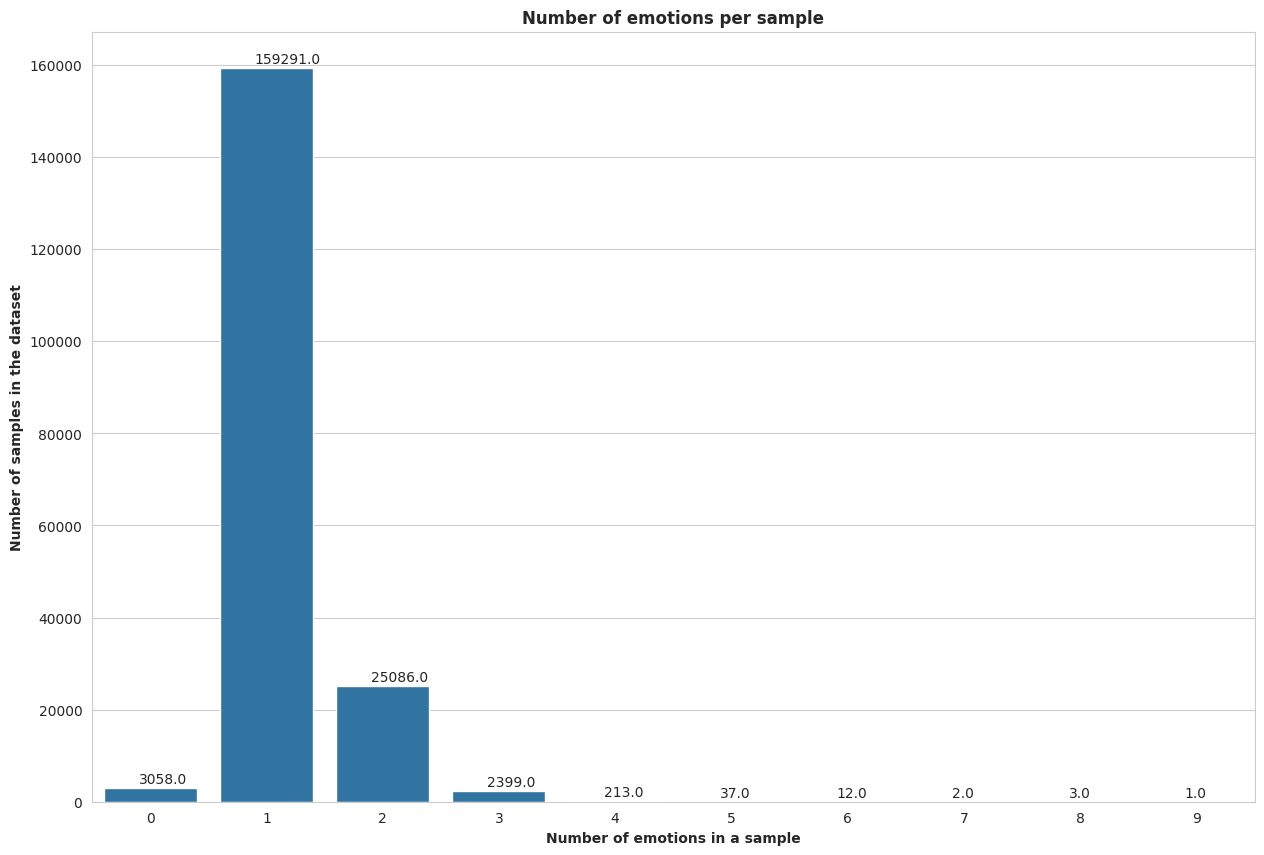

In [ ]:
# Cardinality of GoEmotions and Ekman labels across the dataset
plt.figure(figsize=(15,10))

ax = sns.countplot(x='Cardinality', data=train_GE)

for p in ax.patches:
  value = p.get_height()
  x = p.get_x() + p.get_width() - 0.5
  y = p.get_y() + p.get_height() + 1000
  ax.annotate(value, (x, y))


plt.title("Number of emotions per sample", fontweight='bold')
plt.ylabel("Number of samples in the dataset", fontweight='bold')
plt.xlabel("Number of emotions in a sample", fontweight='bold')
plt.show()

In [ ]:
classes_GE_count = train_GE.loc[:,GE_taxonomy].sum(axis=0).sort_values(ascending=False)


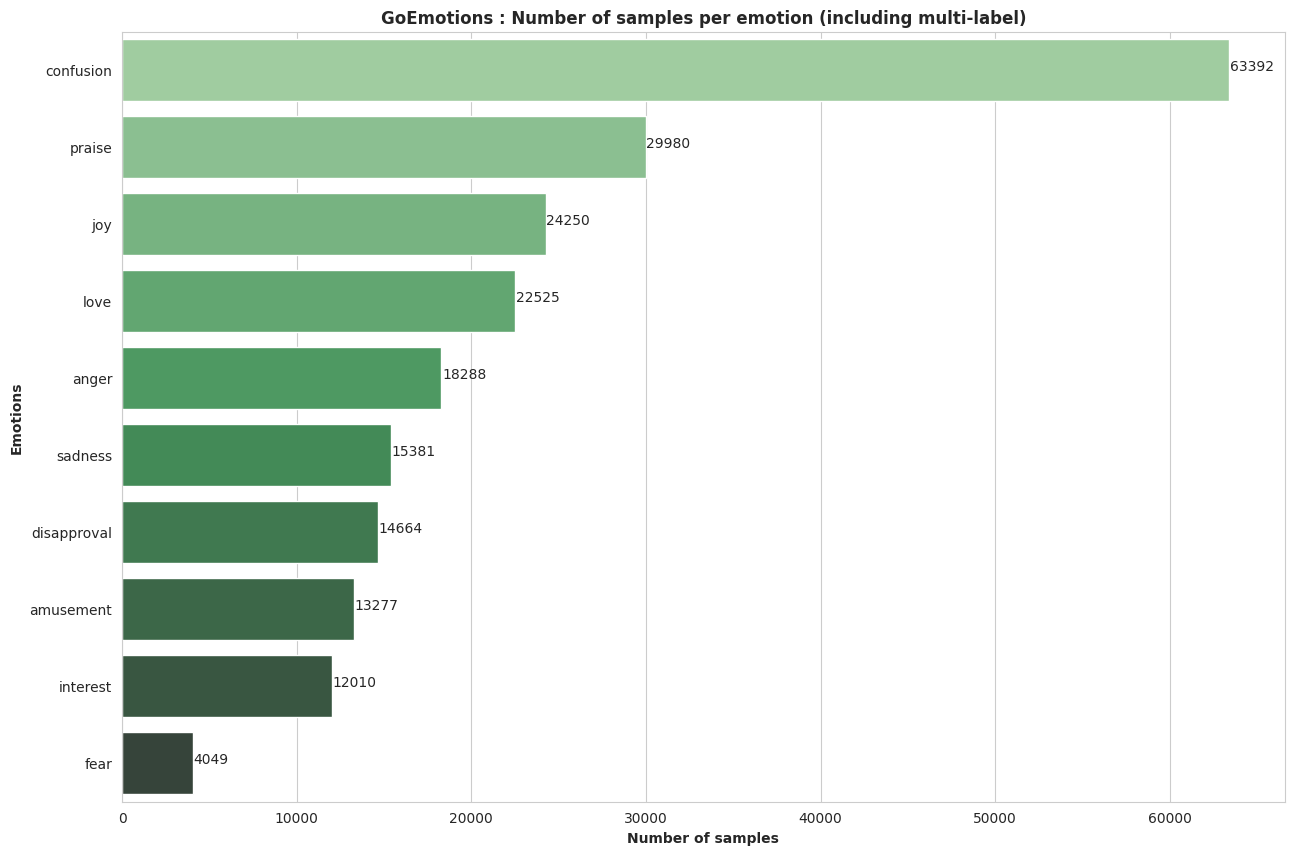

In [ ]:
plt.figure(figsize=(15,10))
ax = sns.barplot(x=classes_GE_count.values, y=classes_GE_count.index, orient='h', palette="Greens_d")

for p in ax.patches:
  value = int(p.get_width())
  x = p.get_x() + p.get_width() + 30
  y = p.get_y() + p.get_height()/2
  ax.annotate(value, (x, y))

plt.title("GoEmotions : Number of samples per emotion (including multi-label)", fontweight='bold')
plt.ylabel("Emotions", fontweight='bold')
plt.xlabel("Number of samples", fontweight='bold')
plt.show()

In [ ]:
train_count_GE = (train_GE.loc[:, GE_taxonomy].sum(axis=0) / size_train)*100
val_count_GE = (val_GE.loc[:, GE_taxonomy].sum(axis=0) / size_val)*100

# Constructing a unique dataset for visualization purposes
balance_GE = pd.DataFrame(data=[train_count_GE, val_count_GE]).T.reset_index(drop=False)
balance_GE.columns = ['Emotion', 'Train', 'Validation']
balance_GE = balance_GE.sort_values('Train', ascending=False)
balance_GE = balance_GE.melt(id_vars='Emotion', var_name='Dataset', value_vars=['Train','Validation'], value_name='Percentage')

# Preview of data
display(balance_GE.head(10))

,Emotion,Dataset,Percentage
0,confusion,Train,33.346309
1,praise,Train,15.770481
2,joy,Train,12.756310
3,love,Train,11.848902
4,anger,Train,9.620099
5,sadness,Train,8.090920
6,disapproval,Train,7.713754
7,amusement,Train,6.984145
8,interest,Train,6.317661
9,fear,Train,2.129909


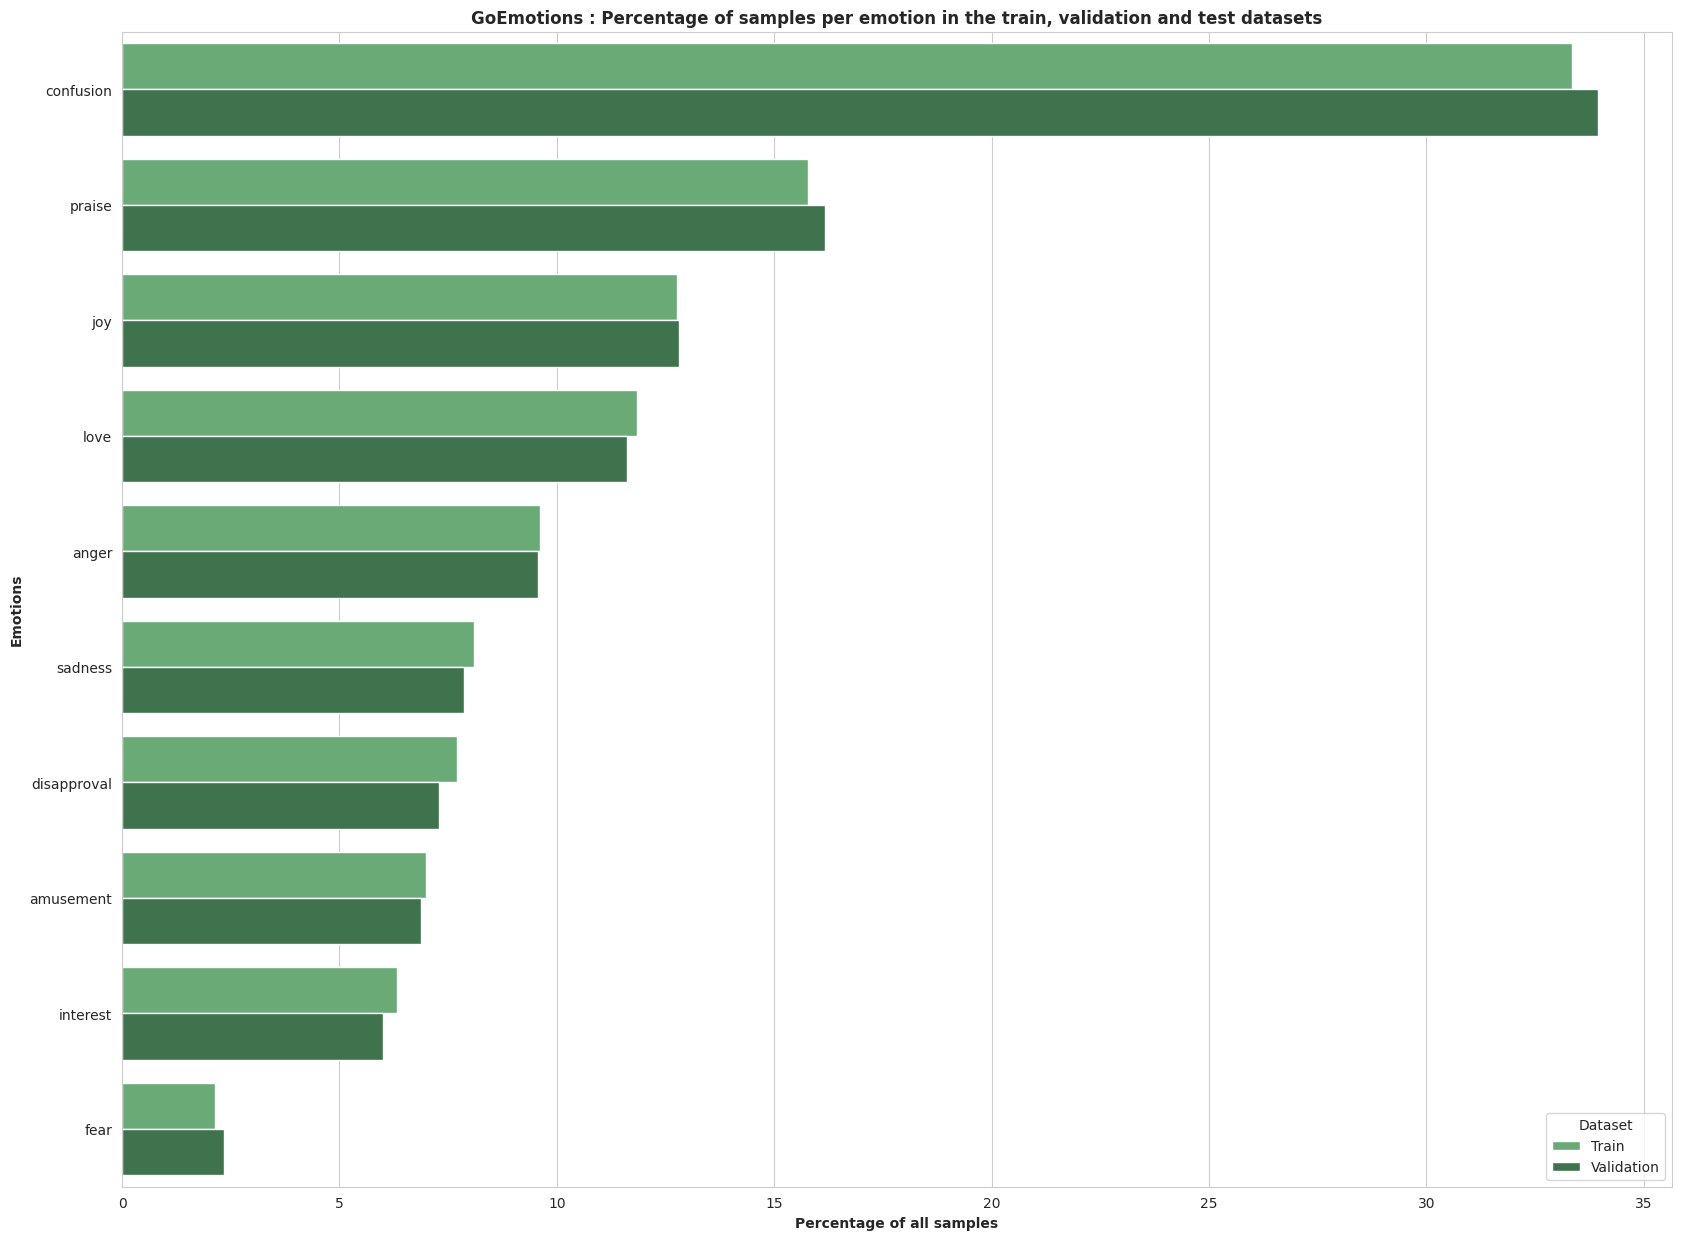

In [ ]:
# Classe Balance visualization on GoEmotions
plt.figure(figsize=(20,15))
sns.barplot(x='Percentage', y='Emotion', data=balance_GE, orient='h', hue='Dataset', palette="Greens_d")
plt.title("GoEmotions : Percentage of samples per emotion in the train, validation and test datasets", fontweight='bold')
plt.ylabel("Emotions", fontweight='bold')
plt.xlabel("Percentage of all samples", fontweight='bold')
plt.show()

In [ ]:
# Computing the number of words per sample
train_GE['Nb_words'] = train_GE['Clean_text'].apply(lambda x: len(x.split()))

# Preview of data
display(train_GE.head(3))

<ipython-input-26-7f122bdbbb0b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_GE['Nb_words'] = train_GE['Clean_text'].apply(lambda x: len(x.split()))


,text,praise,amusement,anger,disapproval,confusion,interest,sadness,fear,joy,love,Clean_text,Cardinality,Nb_words
0,Is there some scripture you could quote me? I'...,1,0,0,0,0,1,0,0,0,0,is there some scripture you could quote me ? i...,2,23
1,Good. Now we just need people to dislike commi...,1,0,0,0,0,0,0,0,0,0,good now we just need people to dislike commie...,1,14
2,This was driving me NUTS!,0,1,0,0,0,0,0,0,0,0,this was driving me nuts !,1,6


In [ ]:
mean_nb_words = {}
for emo in GE_taxonomy:
  nb = train_GE['Nb_words'].loc[train_GE[emo]==1].mean()
  mean_nb_words[emo] = round(nb,2)

# Putting it in a Dataframe
df_length_GE = pd.DataFrame.from_dict(mean_nb_words, orient='index')
df_length_GE.columns = ['Mean_length']
df_length_GE.sort_values('Mean_length', ascending=False, inplace=True)

df_length_GE.head()

,Mean_length
joy,15.21
interest,14.97
fear,14.92
disapproval,14.91
sadness,14.90


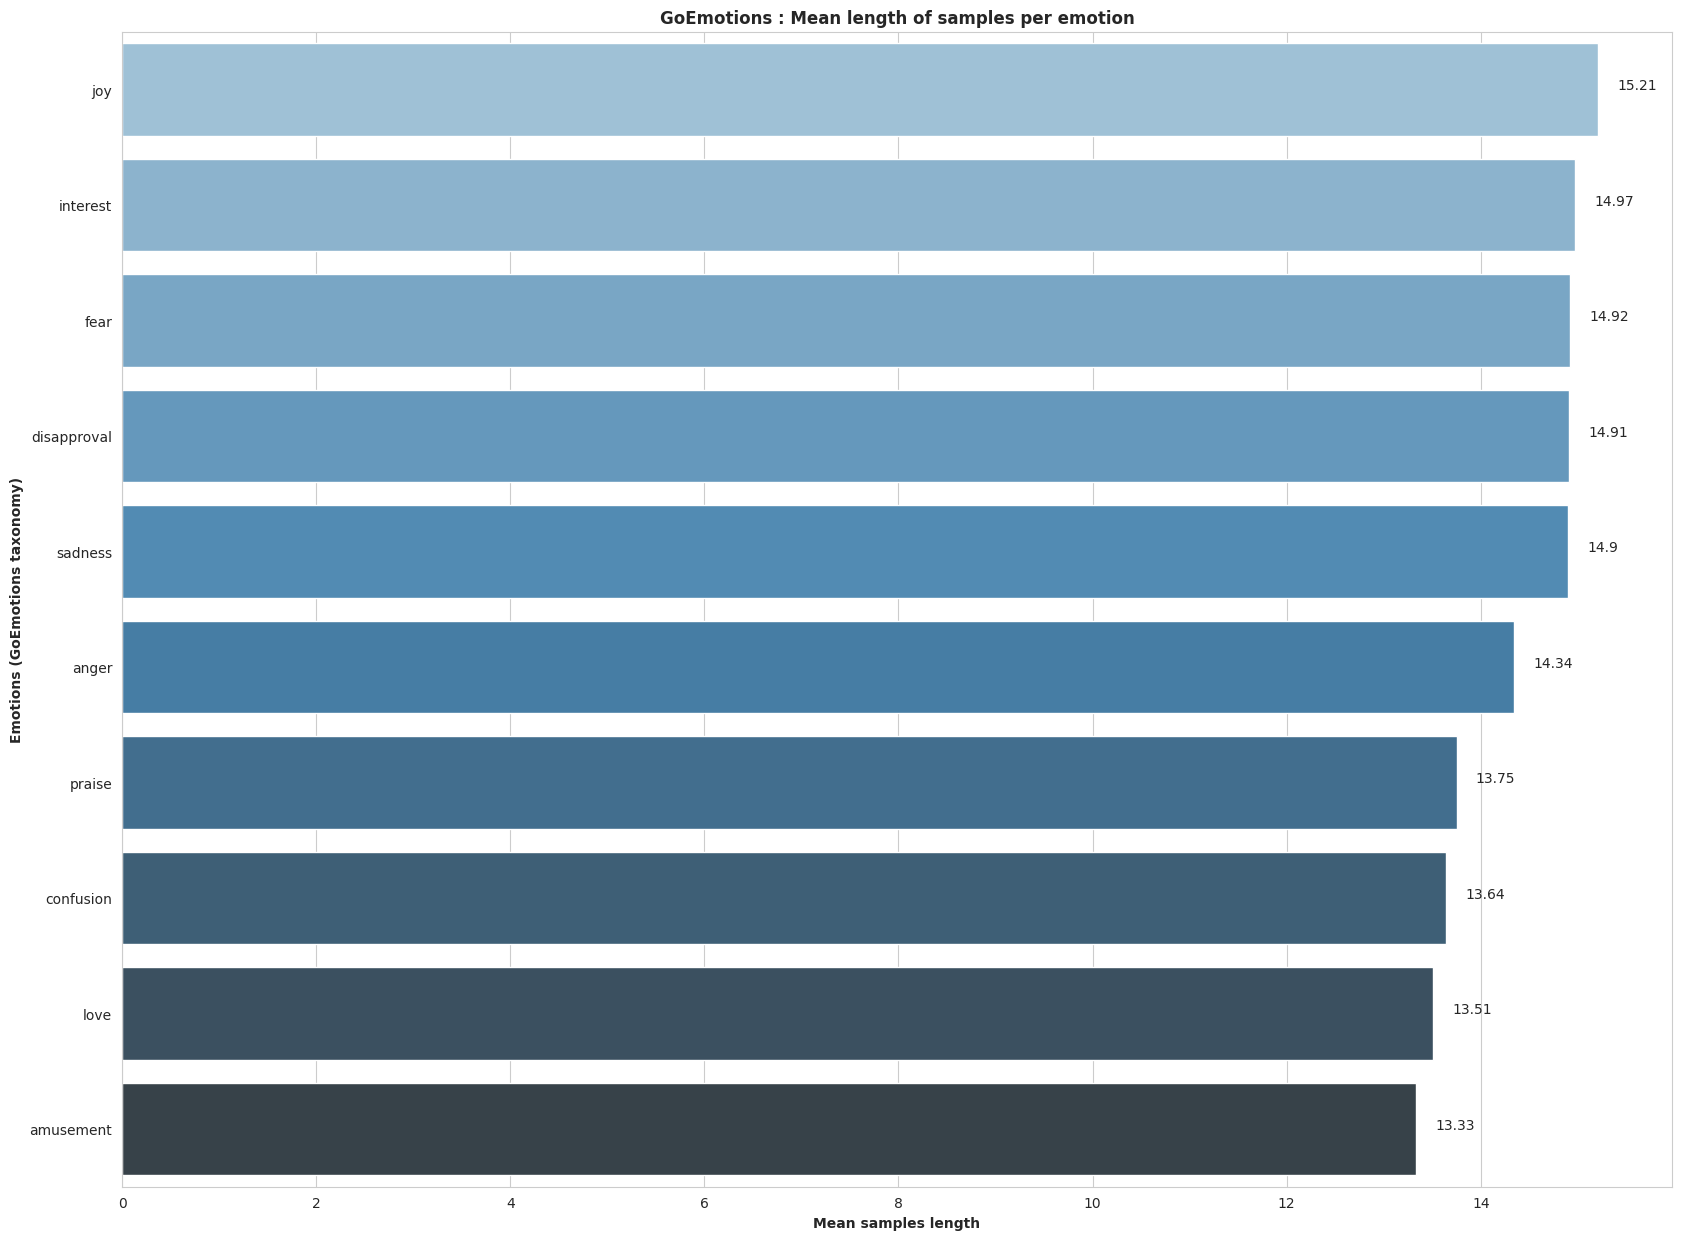

In [ ]:
# Visualizing the mean length of samples per emotion
plt.figure(figsize=(20,15))

ax = sns.barplot(x=df_length_GE['Mean_length'], y=df_length_GE.index, orient='h', palette="Blues_d")
for p in ax.patches:
  value = p.get_width()
  x = p.get_x() + p.get_width() + 0.2
  y = p.get_y() + p.get_height()/2
  ax.annotate(value, (x, y))

plt.title("GoEmotions : Mean length of samples per emotion", fontweight='bold')
plt.ylabel("Emotions (GoEmotions taxonomy)", fontweight='bold')
plt.xlabel("Mean samples length", fontweight='bold')
plt.show()


In [ ]:
# Function to display 10 most frequent words in a list of comments
def plot_top_words_barchart(comments, axes):

    comments = comments.str.split() # split each comment into a list of words
    comments = comments.values.tolist() # from pandas series to lists of words
    corpus = [word for sample in comments for word in sample if word not in list(STOP_WORDS)+["?","!","name"]] # giant corpus of words excluding special characters
    counter = Counter(corpus) # create a counter
    most = counter.most_common(10) # retrieve the 10 most frequent words

    # Plot the 10 top words and their frequencies
    most = [(word, count) for (word, count) in most]
    x, y = [], []
    for word, count in most[:10]:
      x.append(word)
      y.append(count)
    sns.barplot(x=y, y=x , ax=axes, palette="Set2")

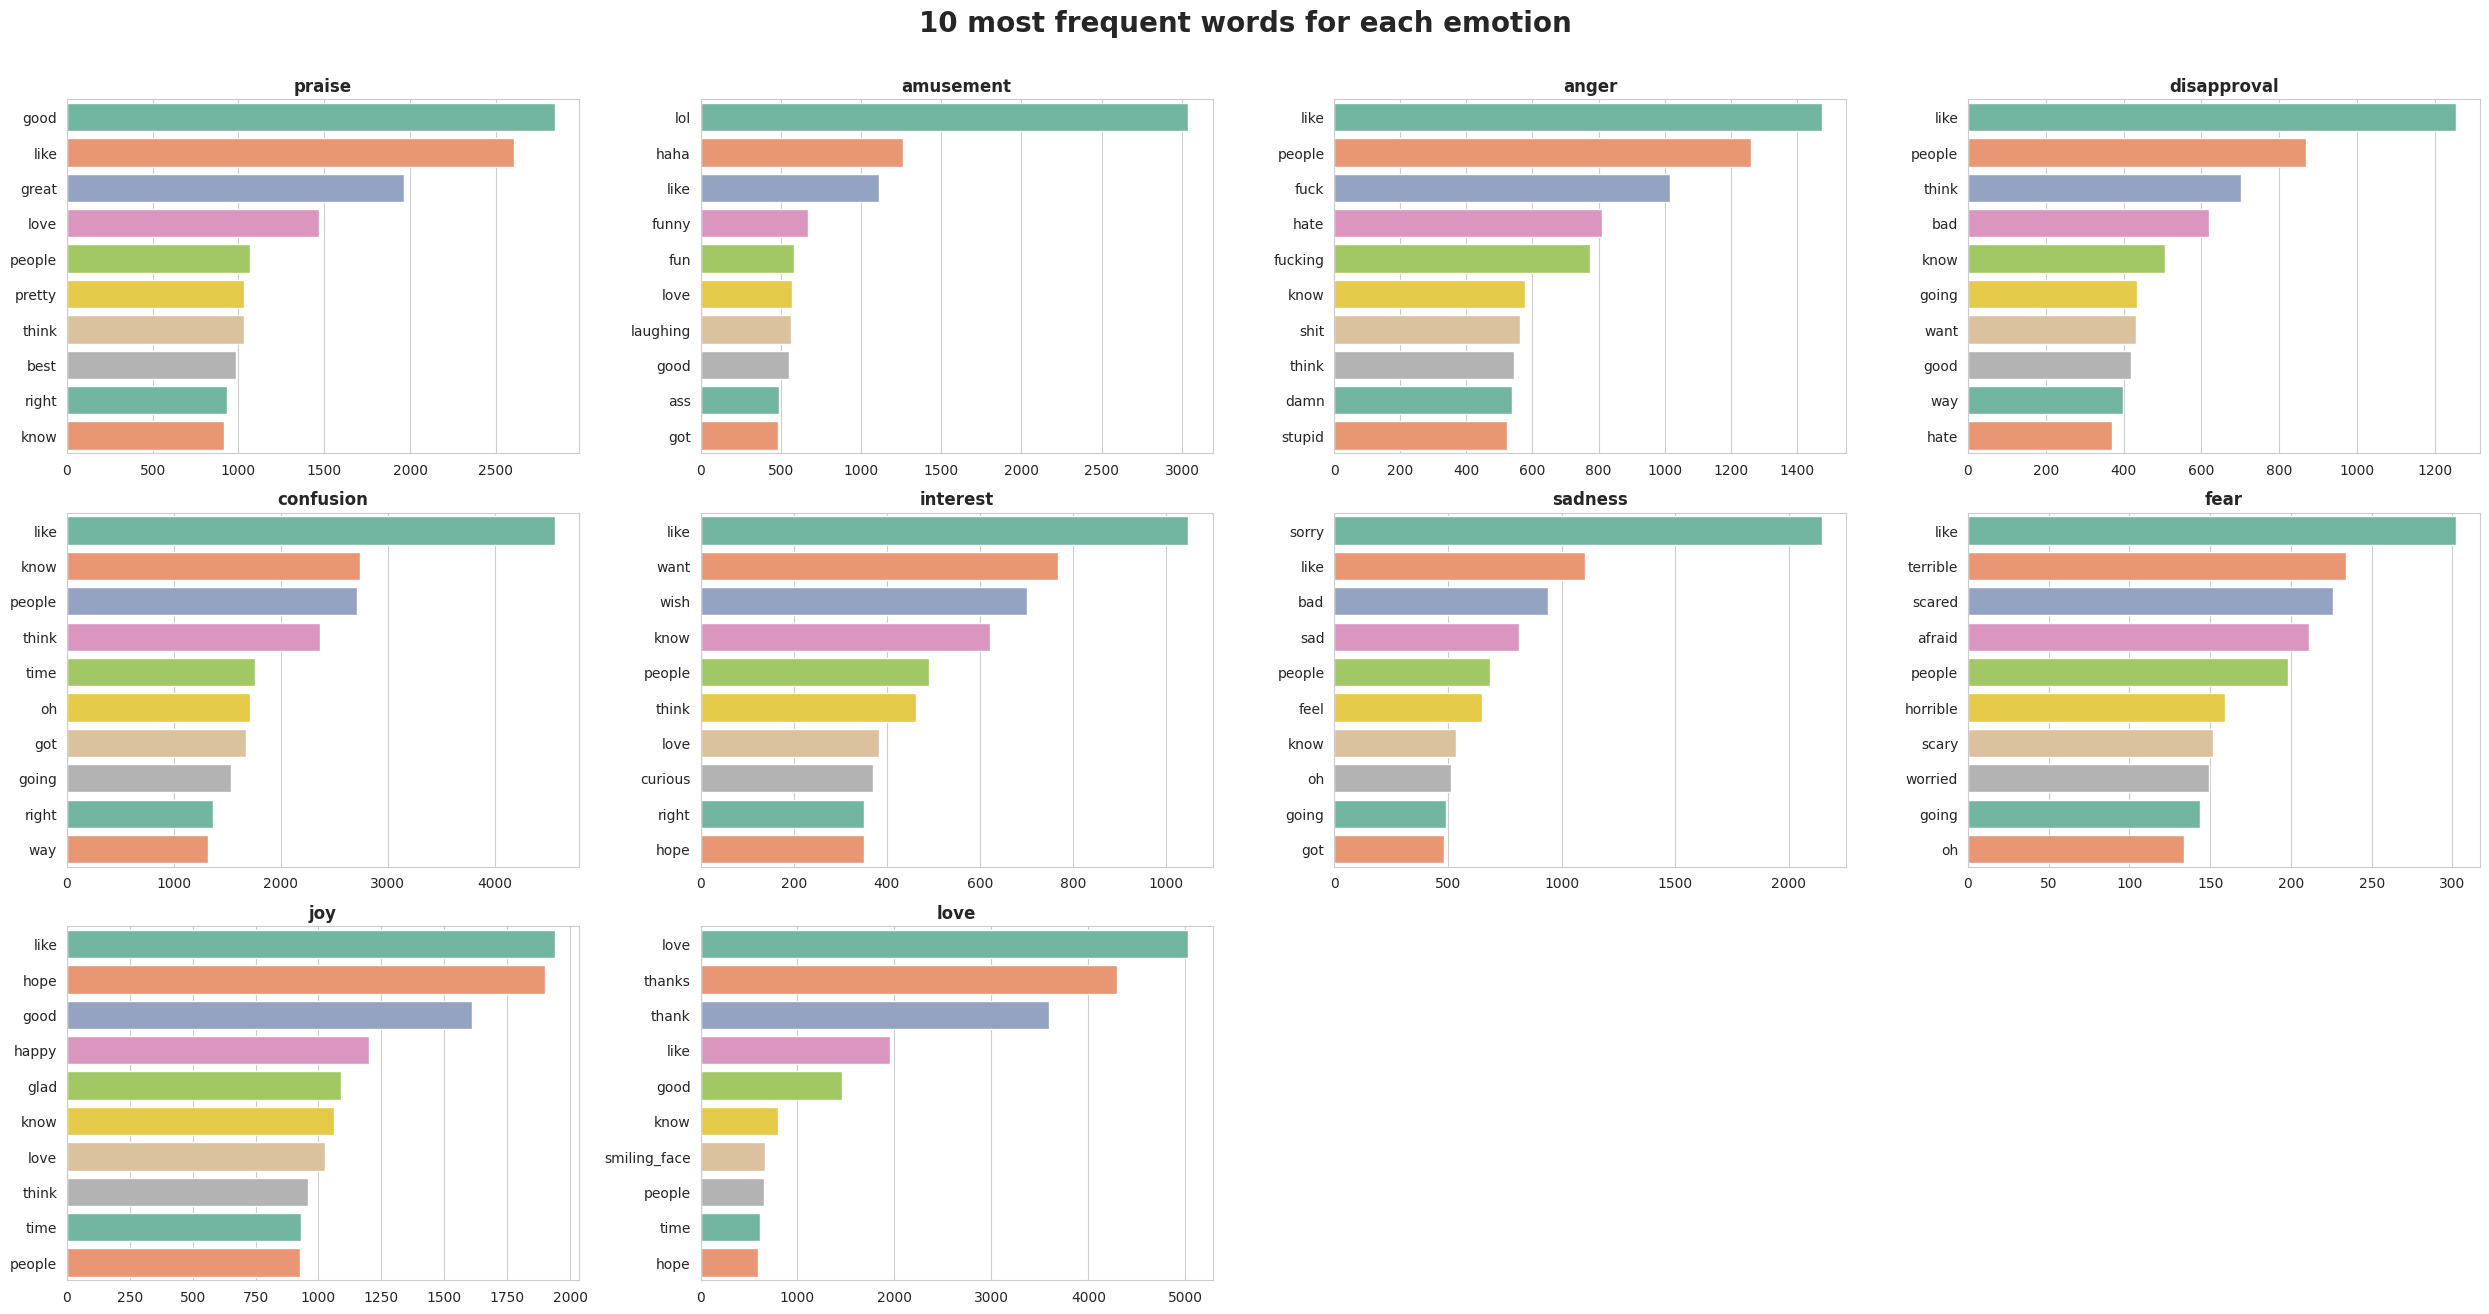

In [ ]:
# Displaying 10 most frequent words for each emotion
fig, axes = plt.subplots(7, 4, figsize=(25, 30))
fig.suptitle('10 most frequent words for each emotion', fontweight="bold", fontsize=20)

# Get the minimum length between axes.flat and GE_taxonomy
num_emotions = min(len(axes.flat), len(GE_taxonomy))

for i, axi in enumerate(axes.flat):
    # Only plot for emotions within the range of GE_taxonomy
    if i < num_emotions:
        plot_top_words_barchart(train_GE.loc[train_GE[GE_taxonomy[i]]==1,"Clean_text"], axi)
        axi.set_title(GE_taxonomy[i], fontweight="bold")
    else:
        # Hide extra subplots if axes.flat is longer than GE_taxonomy
        axi.set_visible(False)

plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [ ]:
train_GE = train_GE[ ['Clean_text'] + GE_taxonomy ]

# Saving datasets for modeling
train_GE.to_csv("/content/drive/MyDrive/train_clean.csv", index = False)

In [ ]:
val_GE = val_GE[ ['Clean_text'] + GE_taxonomy ]

val_GE.to_csv("/content/drive/MyDrive/val_clean.csv", index = False)


In [ ]:
train_GE = pd.read_csv("/content/drive/MyDrive/train_clean.csv")
val_GE = pd.read_csv("/content/drive/MyDrive/val_clean.csv")
print(train_GE.shape)
print(val_GE.shape)


(190102, 11)
(10562, 11)


In [ ]:

# Convert 'Clean_text' column to string type, handling potential NaN values
train_GE['Clean_text'] = train_GE['Clean_text'].astype(str).apply(lambda x: re.sub(r"[^A-Za-z_]+"," ", x))


In [ ]:
!python -m spacy download en_core_web_sm -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 97.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [ ]:
tokenized_train_GE = train_GE["Clean_text"].sample(n=10000, random_state=42).apply(lambda desc: nlp(desc))


In [ ]:
tokenized_train_GE = train_GE["Clean_text"].sample(n=20000, random_state=42).apply(lambda x: nlp(x))

tokenized_train_GE = tokenized_train_GE.apply(lambda doc: [token.lemma_ for token in doc if token.lemma_ not in nlp.Defaults.stop_words])

train_GE.loc[tokenized_train_GE.index, "Clean_token"] = [" ".join(x) for x in tokenized_train_GE]


In [ ]:
nlp = spacy.load("en_core_web_sm")

tokenized_train_GE = train_GE["Clean_text"].iloc[:10000].apply(lambda x: nlp(x))
tokenized_train_GE = tokenized_train_GE.apply(lambda doc: [token.lemma_ for token in doc if token.lemma_ not in nlp.Defaults.stop_words])

train_GE.loc[train_GE.index[:10000], "Clean_token"] = [" ".join(x) for x in tokenized_train_GE]

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [ ]:
vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)

# Fitting the vectorizer and transforming train and test data
tfidf_train_GE = vectorizer.fit_transform(train_GE['Clean_token'])

# Transforming from generators to arrays
tfidf_train_GE = tfidf_train_GE.toarray()

# Validating the shape of train and test data
print(tfidf_train_GE.shape)

(190102, 1000)


In [ ]:
with open("/content/drive/MyDrive/ML-Project-NLP-TrVal-Datasets/emotions.txt", "r") as file:
    GE_taxonomy = file.read().split("\n")

# Clean up GE_taxonomy by removing trailing tabs and empty strings:
GE_taxonomy = [emo.strip() for emo in GE_taxonomy if emo.strip()]

X_train =  tfidf_train_GE
y_train = train_GE.loc[:,GE_taxonomy].values

# Shape validation
print("The shape of X_train is : ", X_train.shape)
print("The shape of y_train is : ", y_train.shape)

The shape of X_train is :  (190102, 1000)
The shape of y_train is :  (190102, 10)


In [ ]:
display(train_GE.head(3))


,Clean_text,praise,amusement,anger,disapproval,confusion,interest,sadness,fear,joy,love,Clean_token
0,is there some scripture you could quote me i w...,1,0,0,0,0,1,0,0,0,0,scripture quote I I like read sure
1,good now we just need people to dislike commie...,1,0,0,0,0,0,0,0,0,0,good need people dislike commie
2,this was driving me nuts,0,1,0,0,0,0,0,0,0,0,drive I nuts


In [ ]:
dummy_preds = np.zeros_like(y_train)
dummy_preds[:,-1] = 1
dummy_preds

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [ ]:
# Model evaluation function
def model_eval(y_true, y_pred_labels, emotions):

    # Defining variables
    precision = []
    recall = []
    f1 = []

    # Per emotion evaluation
    idx2emotion = {i: e for i, e in enumerate(emotions)}

    for i in range(len(emotions)):

        # Computing precision, recall and f1-score
        p, r, f1_score, _ = precision_recall_fscore_support(y_true[:, i], y_pred_labels[:, i], average="binary")

        # Append results in lists
        precision.append(round(p, 2))
        recall.append(round(r, 2))
        f1.append(round(f1_score, 2))

    # Macro evaluation
    macro_p, macro_r, macro_f1_score, _ = precision_recall_fscore_support(y_true, y_pred_labels, average="macro")

    # Append results in lists
    precision.append(round(macro_p, 2))
    recall.append(round(macro_r, 2))
    f1.append(round(macro_f1_score, 2))

    # Converting results to a dataframe
    df_results = pd.DataFrame({"Precision":precision, "Recall":recall, 'F1':f1})
    df_results.index = emotions+['MACRO-AVERAGE']

    return df_results

In [ ]:
model_eval(y_train, dummy_preds, GE_taxonomy)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

,Precision,Recall,F1
praise,0.00,0.0,0.00
amusement,0.00,0.0,0.00
anger,0.00,0.0,0.00
disapproval,0.00,0.0,0.00
confusion,0.00,0.0,0.00
interest,0.00,0.0,0.00
sadness,0.00,0.0,0.00
fear,0.00,0.0,0.00
joy,0.00,0.0,0.00
love,0.12,1.0,0.21


In [ ]:
import numpy as np
from sklearn.linear_model import RidgeClassifier
from sklearn.multioutput import MultiOutputClassifier

X_train_sample = np.array(X_train[:10000], dtype=np.float32)
y_train_sample = np.array(y_train[:10000], dtype=np.float32)

rc = RidgeClassifier(class_weight='balanced')
classifier = MultiOutputClassifier(rc, n_jobs=2)

classifier.fit(X_train_sample, y_train_sample)

MultiOutputClassifier(estimator=RidgeClassifier(class_weight='balanced'),
                      n_jobs=2)

In [ ]:
classifier_preds = classifier.predict(X_train_sample)
classifier_preds

array([[1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]], dtype=float32)

In [ ]:
model_eval(y_train_sample, classifier_preds, GE_taxonomy)

,Precision,Recall,F1
praise,0.39,0.77,0.52
amusement,0.32,0.91,0.47
anger,0.31,0.84,0.45
disapproval,0.23,0.83,0.36
confusion,0.53,0.74,0.62
interest,0.21,0.85,0.34
sadness,0.29,0.87,0.43
fear,0.18,0.97,0.30
joy,0.32,0.77,0.45
love,0.49,0.85,0.62


In [ ]:
def predict_samples(text_samples, model):

    # Text preprocessing and cleaning
    text_samples = pd.Series(text_samples)
    text_samples_clean = text_samples.apply(preprocess_corpus)

    # Create tfidf representation
    tfidf_text_samples_clean = vectorizer.transform(text_samples_clean)

    # labels predictions
    samples_pred_labels = model.predict(tfidf_text_samples_clean)
    samples_pred_labels_df = pd.DataFrame(samples_pred_labels)
    samples_pred_labels_df = samples_pred_labels_df.apply(lambda x: [GE_taxonomy[i] for i in range(len(x)) if x[i]==1], axis=1)

    return pd.DataFrame({"Text":text_samples, "Emotions":list(samples_pred_labels_df)})

In [ ]:
predict_samples("Oh man, I forgot about eBay! I have some old textbooks Iâ€™ve been meaning to put on there too." , classifier)


,Text,Emotions
0,"Oh man, I forgot about eBay! I have some old t...","[disapproval, confusion, interest]"


In [ ]:
!pip install transformers
!pip install emoji
!pip install contractions

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight

# Packages to define a BERT model
from transformers import TFBertModel, BertTokenizerFast, BertConfig

# Keras and TensorFlow packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal

In [ ]:
full_text = pd.concat([train_GE['Clean_text'], val_GE['Clean_text']])
max_length = full_text.apply(lambda x: len(x.split())).max()
max_length

84

In [ ]:
model_name = 'bert-base-uncased'
config = BertConfig.from_pretrained(model_name, output_hidden_states=False)
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
def create_model(nb_labels):
  # Load the MainLayer
  bert = transformer_model.layers[0]

  # Build the model inputs
  input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
  attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32')
  inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}

  # Instead of directly casting to tf.int32, pass the KerasTensors to BERT within a Lambda layer
  # This allows Keras to handle the conversion and data flow correctly
  # Specify the output_shape for the Lambda layer
  bert_output = layers.Lambda(
      lambda x: bert(input_ids=x[0], attention_mask=x[1])[1],
      output_shape=(config.hidden_size,)  # Output shape of BERT's pooled output
  )([inputs['input_ids'], inputs['attention_mask']])

  dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
  pooled_output = dropout(bert_output, training=False)  # Use bert_output here

  # Then build the model output
  emotion = Dense(units=nb_labels, activation="sigmoid", kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='emotion')(pooled_output)
  outputs = emotion

  # And combine it all in a model object
  model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel')

  return model

In [ ]:
model = create_model(10)

# Take a look at the model
model.summary()

Model: "BERT_MultiLabel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 84)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 84)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 768)            │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pooled_output (Dropout)   │ (None, 768)            │              0 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ emotion (Dense)           │ (None, 10)             │          7,690 │ pooled_output[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 7,690 (30.04 KB)

 Trainable params: 7,690 (30.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Creating train, validation and test variables
X_train = train_GE['Clean_text']
y_train = train_GE.loc[:, GE_taxonomy].values.astype(float)

X_val = val_GE['Clean_text']
y_val = val_GE.loc[:, GE_taxonomy].values.astype(float)

# Tokenizing train data
train_token = tokenizer(
    text = X_train.to_list(),
    add_special_tokens = True,
    max_length = max_length,
    truncation = True,
    padding = 'max_length',
    return_tensors = 'tf',
    return_token_type_ids = True,
    return_attention_mask = True,
    verbose = True)

# Tokenizing valisation data
val_token = tokenizer(
    text = X_val.to_list(),
    add_special_tokens = True,
    max_length = max_length,
    truncation = True,
    padding = 'max_length',
    return_tensors = 'tf',
    return_token_type_ids = True,
    return_attention_mask = True,
    verbose = True)



In [ ]:
train = {'input_ids': train_token['input_ids'], 'attention_mask': train_token['attention_mask'],'token_ids': train_token['token_type_ids']}
val = {'input_ids': val_token['input_ids'], 'attention_mask': val_token['attention_mask'],'token_ids': val_token['token_type_ids']}

In [ ]:
train_tensor = tf.data.Dataset.from_tensor_slices((train, y_train)).shuffle(len(train)).batch(16)
val_tensor = tf.data.Dataset.from_tensor_slices((val, y_val)).shuffle(len(val)).batch(16)

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

def calculating_class_weights(y_true):
    number_dim = np.shape(y_true)[1]
    weights = np.empty((number_dim, 2))

    for i in range(number_dim):
        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.array([0., 1.]),
            y=y_true[:, i].ravel()
        )
        weights[i, :] = class_weights
    return weights

class_weights = calculating_class_weights(y_train)


In [ ]:
import tensorflow.keras.backend as K

def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean(
            (weights[:, 0] ** (1 - y_true)) * (weights[:, 1] ** y_true) * K.binary_crossentropy(y_true, y_pred),
            axis=-1
        )
    return weighted_loss

# Set an optimizer
optimizer = Adam(
    learning_rate=5.e-05,
    )

# Set loss
loss = get_weighted_loss(class_weights)


# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss)

# train the model
history = model.fit(train_tensor,
                    epochs=5,
                    validation_data=val_tensor,
                    )


Epoch 1/5
  536/11882 ━━━━━━━━━━━━━━━━━━━━ 14:06 75ms/step - loss: 0.6926

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf

# Load the model weights using TensorFlow's load_weights function
model.load_weights('/content/drive/MyDrive/ML-Project-NLP-TrVal-Datasets/bert-weights.weights.h5')

# Remove the pd.read_hdf line, as it's not applicable for model weights


In [ ]:
# prompt: train the model again. i mwan train the bert-weights.weights.h5

from tensorflow.keras.initializers import TruncatedNormal

# ... (Your existing code)

# Assuming 'model' is your compiled BERT model
history = model.fit(train_tensor,
                    epochs=5, # You can adjust the number of epochs
                    validation_data=val_tensor,
                    )

# Save the model weights after training
model.save_weights('/content/drive/MyDrive/ML-Project-NLP-TrVal-Datasets/bert-weights.weights.h5')


Epoch 1/5
11882/11882 ━━━━━━━━━━━━━━━━━━━━ 987s 83ms/step - loss: 0.6130 - val_loss: 0.6091
Epoch 2/5
11882/11882 ━━━━━━━━━━━━━━━━━━━━ 1061s 85ms/step - loss: 0.6118 - val_loss: 0.6077
Epoch 3/5
11882/11882 ━━━━━━━━━━━━━━━━━━━━ 971s 82ms/step - loss: 0.6108 - val_loss: 0.6065
Epoch 4/5
11882/11882 ━━━━━━━━━━━━━━━━━━━━ 983s 82ms/step - loss: 0.6096 - val_loss: 0.6054
Epoch 5/5
11882/11882 ━━━━━━━━━━━━━━━━━━━━ 972s 82ms/step - loss: 0.6083 - val_loss: 0.6042


In [ ]:
y_pred_proba = model.predict(train)


5941/5941 ━━━━━━━━━━━━━━━━━━━━ 785s 132ms/step


In [ ]:
y_pred_proba = model.predict(val)


331/331 ━━━━━━━━━━━━━━━━━━━━ 45s 137ms/step


In [ ]:
def proba_to_labels(y_pred_proba, threshold=0.8):

    y_pred_labels = np.zeros_like(y_pred_proba)

    for i in range(y_pred_proba.shape[0]):
        for j in range(y_pred_proba.shape[1]):
            if y_pred_proba[i][j] > threshold:
                y_pred_labels[i][j] = 1
            else:
                y_pred_labels[i][j] = 0

    return y_pred_labels

In [ ]:
y_pred_labels = proba_to_labels(y_pred_proba)


In [ ]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def model_eval(y_true, y_pred_labels, emotions):
    precision, recall, f1 = [], [], []

    idx2emotion = {i: e for i, e in enumerate(emotions)}

    for i in range(len(emotions)):
        p, r, f1_score, _ = precision_recall_fscore_support(y_true[:, i], y_pred_labels[:, i], average="binary")
        precision.append(round(p, 2))
        recall.append(round(r, 2))
        f1.append(round(f1_score, 2))

    macro_p, macro_r, macro_f1_score, _ = precision_recall_fscore_support(y_true, y_pred_labels, average="macro")

    weighted_p, weighted_r, weighted_f1_score, _ = precision_recall_fscore_support(y_true, y_pred_labels, average="weighted")


    precision.extend([round(macro_p, 2), round(weighted_p, 2)])
    recall.extend([round(macro_r, 2), round(weighted_r, 2)])
    f1.extend([round(macro_f1_score, 2), round(weighted_f1_score, 2)])

    df_results = pd.DataFrame({"Precision": precision, "Recall": recall, 'F1': f1})
    df_results.index = emotions + ['MACRO-AVERAGE', 'WEIGHTED-AVERAGE']

    return df_results


In [ ]:
def proba_to_labels_opt(y_true, y_pred_proba):

    '''
    Inputs:
        y_true: Ground truth labels
        y_pred_proba: predicted probabilities

    Outputs :
        best_y_pred_labels: preticted labels associated with best threshold
        best_t: best threshold
        best_macro_f1: macro f1-score associated with predicted labels
    '''

    # range of possible thresholds
    thresholds = np.arange(0.7, 0.99, 0.01)

    # Computing threshold that maximizes macro f1-score
    best_y_pred_labels = np.zeros_like(y_pred_proba)
    best_t = 0
    best_macro_f1 = 0

    # Iterating through possible thresholds
    for t in thresholds:

        y_pred_labels = proba_to_labels(y_pred_proba, t)

        _, _, macro_f1, _ = precision_recall_fscore_support(y_true, y_pred_labels, average="macro")

        if macro_f1 > best_macro_f1:
            best_macro_f1 = macro_f1
            best_t = t
            best_y_pred_labels = y_pred_labels

    return best_y_pred_labels, best_t, best_macro_f1

In [ ]:

# Compute label predictions and corresponding optimal thresholds
y_pred_labels_opt, threshold_opt, macro_f1_opt = proba_to_labels_opt(y_train, y_pred_proba)
print("The model's threshold is {}".format(threshold_opt))
print("The model's best macro-f1 is {}".format(macro_f1_opt))

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

The model's threshold is 0.7
The model's best macro-f1 is 0.22092775813623317


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
model_eval(y_train, y_pred_labels_opt, GE_taxonomy)


,Precision,Recall,F1
praise,0.42,0.15,0.22
amusement,0.26,0.27,0.27
anger,0.31,0.29,0.30
disapproval,0.22,0.09,0.13
confusion,0.57,0.06,0.11
interest,0.37,0.17,0.23
sadness,0.30,0.14,0.19
fear,0.10,0.17,0.13
joy,0.33,0.11,0.16
love,0.49,0.44,0.46


In [ ]:
sum(np.sum(y_pred_labels_opt, axis=1)==0)


115922

In [ ]:
y_pred_labels_opt_h = np.copy(y_pred_labels_opt)

# if no predictions ==> label with highest proba
for i, pred in enumerate(y_pred_labels_opt_h):
    if pred.sum()==0:
        pred[np.argmax(y_pred_labels_opt[i])]=1

# Evaluation
model_eval(y_train, y_pred_labels_opt_h, GE_taxonomy)

,Precision,Recall,F1
praise,0.18,0.75,0.29
amusement,0.26,0.27,0.27
anger,0.31,0.29,0.30
disapproval,0.22,0.09,0.13
confusion,0.57,0.06,0.11
interest,0.37,0.17,0.23
sadness,0.30,0.14,0.19
fear,0.10,0.17,0.13
joy,0.33,0.11,0.16
love,0.49,0.44,0.46


In [ ]:

# Handling empty predictions
y_pred_labels_opt_n = np.copy(y_pred_labels_opt)

# if no predictions ==> neutral
for pred in y_pred_labels_opt_n:
    if pred.sum()==0:
        pred[-1]=1

# Evaluation
model_eval(y_train, y_pred_labels_opt_n, GE_taxonomy)

,Precision,Recall,F1
praise,0.42,0.15,0.22
amusement,0.26,0.27,0.27
anger,0.31,0.29,0.30
disapproval,0.22,0.09,0.13
confusion,0.57,0.06,0.11
interest,0.37,0.17,0.23
sadness,0.30,0.14,0.19
fear,0.10,0.17,0.13
joy,0.33,0.11,0.16
love,0.14,0.86,0.24


In [ ]:
model.save_weights('/content/drive/MyDrive/ML-Project-NLP-TrVal-Datasets/bert-weights.weights.h5')

In [ ]:
with open("/content/drive/MyDrive/ML-Project-NLP-TrVal-Datasets/emotions.txt", "r") as file:
    Ekman_taxonomy = file.read().split("\n")
print("Emotions on GoEmotions taxonomy are : \n{}".format(GE_taxonomy))

Emotions on GoEmotions taxonomy are : 
['praise', 'amusement', 'anger', 'disapproval', 'confusion', 'interest', 'sadness', 'fear', 'joy', 'love']


In [ ]:
def GE_to_Ekman(GE_labels):

    # Create a dataframe of GoEmotions labels
    df_GE = pd.DataFrame(GE_labels, columns=GE_taxonomy)

    # Create an empty dataframe of Ekman labels
    df_Ekman  = pd.DataFrame(np.zeros((len(GE_labels), len(Ekman_taxonomy))), columns=Ekman_taxonomy)

    for i in range(len(df_GE)):

        if df_GE.loc[i,['anger', 'disapproval']].sum() >= 1:
            df_Ekman.loc[i,'anger'] = 1


        if df_GE.loc[i,['fear']].sum() >= 1:
            df_Ekman.loc[i,'fear'] = 1

        if df_GE.loc[i,['joy','love', 'amusement', 'interest', 'praise']].sum() >= 1:
            df_Ekman.loc[i,'joy'] = 1

        if df_GE.loc[i,['sadness']].sum() >= 1:
            df_Ekman.loc[i,'sadness'] = 1

        if df_GE.loc[i,[ 'confusion']].sum() >= 1:
            df_Ekman.loc[i,'confusion'] = 1

    return df_Ekman.values